<a href="https://colab.research.google.com/github/DeboraOliver/forecasting_siconfi_dtp/blob/main/PROJETO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PARTE 2



In [22]:
import pandas as pd
import numpy as np

#gráficos
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# calculo estatistico e a simulação de monte carlo
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format
sns.set_theme(style="darkgrid")

In [23]:
df = pd.read_csv('/content/data.csv')
df.head()

,exercicio,periodo,periodo_numero,periodicidade,instituicao,pctg_dtp,valor_dtp,valor_rcl_ajustada
0,2017,1,20171,Q,Prefeitura Municipal de São Paulo - SP,37.58,16326772007.75,43449832401.89
1,2017,2,20172,Q,Prefeitura Municipal de São Paulo - SP,37.42,16481537019.94,44046903764.54
2,2017,3,20173,Q,Prefeitura Municipal de São Paulo - SP,35.80,16936899034.25,47305318527.64
3,2018,1,20181,Q,Prefeitura Municipal de São Paulo - SP,35.49,17255542224.74,48624090109.12
4,2018,2,20182,Q,Prefeitura Municipal de São Paulo - SP,35.20,17530845495.88,49801405650.61


# Análise Exploratória

In [24]:
figura = px.line(title = 'Histórico da Despesa de Pessoal e a Receita Corrente Liquida (em R$ Bilhões)')
for i in df.columns[-2:]:
  figura.add_scatter(x = df['periodo_numero'].astype(str), y = df[i], name = i, fill='tozeroy')
figura.show()

In [25]:
#Adiciona a sazonalidade
valores = []
padrao = [0, 1, 2, 3]

for ano in df['exercicio']:

  diferenca = ano - 2016
  valor = padrao[diferenca % len(padrao)]
  valores.append(valor)

df['eleicao'] = valores

df
#0 = Ano de eleição, 1 = 1º ano do mandato,
#2 = 2º ano do mandato e 3 = 3º ano do mandato

,exercicio,periodo,periodo_numero,periodicidade,instituicao,pctg_dtp,valor_dtp,valor_rcl_ajustada,eleicao
0,2017,1,20171,Q,Prefeitura Municipal de São Paulo - SP,37.58,16326772007.75,43449832401.89,1
1,2017,2,20172,Q,Prefeitura Municipal de São Paulo - SP,37.42,16481537019.94,44046903764.54,1
2,2017,3,20173,Q,Prefeitura Municipal de São Paulo - SP,35.80,16936899034.25,47305318527.64,1
3,2018,1,20181,Q,Prefeitura Municipal de São Paulo - SP,35.49,17255542224.74,48624090109.12,2
4,2018,2,20182,Q,Prefeitura Municipal de São Paulo - SP,35.20,17530845495.88,49801405650.61,2
5,2018,3,20183,Q,Prefeitura Municipal de São Paulo - SP,36.92,18025981576.42,48830405884.01,2
6,2019,1,20191,Q,Prefeitura Municipal de São Paulo - SP,36.15,18346577308.85,50757883723.53,3
7,2019,2,20192,Q,Prefeitura Municipal de São Paulo - SP,35.48,18429410069.65,51942413607.27,3
8,2019,3,20193,Q,Prefeitura Municipal de São Paulo - SP,35.36,19154205068.10,54166943978.98,3
9,2020,1,20201,Q,Prefeitura Municipal de São Paulo - SP,34.03,19241921204.63,56549458415.67,0


### Variância

Medimos o quanto os dados estão variando em relação à média. Assim, quanto menor a variância menor é a volatilidade.

In [77]:
variancias = []
media_variacoes = round(df['pctg_dtp'].sum() / len(df),2)

for i in df['pctg_dtp']:
  variancia = ((i - media_variacoes) ** 2).sum() / len(df)
  variancias.append(variancia)

df['variancias'] = variancias

df.groupby(['exercicio','eleicao'])['variancias'].mean().reset_index()

,exercicio,eleicao,variancias
0,2017,1,0.50
1,2018,2,0.22
2,2019,3,0.15
3,2020,0,0.00
4,2021,1,0.37
5,2022,2,1.17


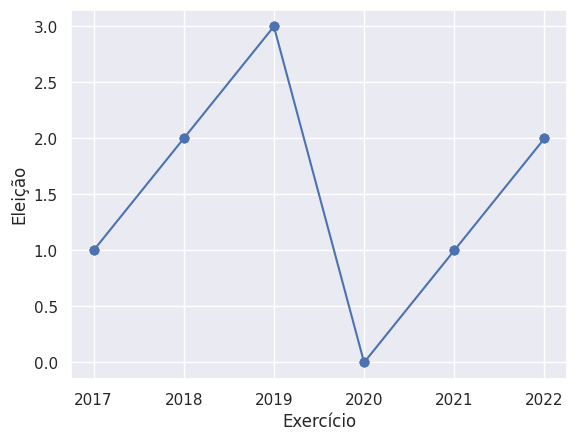

In [80]:
# plot
plt.plot('exercicio', 'eleicao', data=df, linestyle='-', marker='o')
plt.xlabel('Exercício')
plt.ylabel('Eleição')
plt.show()

# Análise Estatística

# SIMULAÇÃO DE MONTE-CARLO

In [31]:
def monte_carlo_previsao(dataset, ativo, quad_a_frente, simulacoes):
  dataset = dataset.copy()
  dataset = pd.DataFrame(dataset[ativo])

  #normalizando o df
  dataset_normalizado = dataset.copy()
  for i in dataset:
    dataset_normalizado[i] = dataset[i] / dataset[i][0]

  #retorno ou a variação de um para ontem
  dataset_taxa_retorno = np.log(1 + dataset_normalizado.pct_change())

  #preencho o primeiro elemneto com 0
  dataset_taxa_retorno.fillna(0, inplace=True)

  #calculo da média
  media = dataset_taxa_retorno.mean()

  #calculo da variância (qto os valores estão afastados da média)
  variancia = dataset_taxa_retorno.var()

  #o drift indica a direção que as taxas de retorno tiveram no passado (+ ou -).
  #Para isso precisamos da media e da variancia anterioemente calculadas
  drift = media - (0.5 * variancia)

  # desvio padrão
  desvio_padrao = dataset_taxa_retorno.std()

  #gera um conj de nº aleatorios que seguem uma distribuição normal
  #gera uma matriz com 4 linhas e 3 colunas
  Z = stats.norm.ppf(np.random.rand(quad_a_frente, simulacoes))

  # print(sns.histplot(Z))

  #retorno quadrimestrais previstas para os PROXIMOS 3 QUADRIMESTRES, NÃO SÃO REAIS
  retornos_quad = np.exp(drift.values + desvio_padrao.values * Z)

  #previsões dos preços futuros
  previsoes = np.zeros_like(retornos_quad) #inicializamos com zeros com msm formato da
  previsoes[0] = dataset.iloc[-1]

  #cada taxa depende da anterior
  for quadrimestre in range(1, quad_a_frente):
    previsoes[quadrimestre] = previsoes[quadrimestre - 1] * retornos_quad[quadrimestre]

  figura = px.line(title = 'Previsões para os proximos 3 quadrimestres da Porcentagem de Despesa Total com Pessoal - ' + ativo)
  figura.add_scatter(x = [1], y = [29.47], name = 'Valor real')
  for i in range(len(previsoes.T)):
    figura.add_scatter(y = previsoes.T[i], name = f" {i + 1}ª Simulação")
  figura.show()

  return previsoes.T

monte_carlo = monte_carlo_previsao(df[['periodo_numero','pctg_dtp','eleicao','valor_rcl_ajustada']], ativo = 'pctg_dtp', quad_a_frente = 4, simulacoes=3)
monte_carlo

array([[29.        , 25.85363024, 27.37159588, 28.03329508],
       [29.        , 29.63436431, 32.99710931, 28.20082142],
       [29.        , 29.82905297, 33.3675889 , 34.9108694 ]])

# Média-Móvel Simples

In [32]:
df_mma = df[['periodo_numero','pctg_dtp']]

#Quanto maior a janela, mais suavizada será a série temporal, mas também haverá um atraso maior na detecção de mudanças de tendência.
window_size = 3

df_mma['pctg_dtp_moving_avg'] = df_mma['pctg_dtp'].rolling(window=window_size).mean()

df_mma
#29.47

,exercicio,periodo,pctg_dtp,pctg_dtp_moving_avg
0,2017,1,37.58,NaN
1,2017,2,37.42,NaN
2,2017,3,35.80,36.93
3,2018,1,35.49,36.24
4,2018,2,35.20,35.50
5,2018,3,36.92,35.87
6,2019,1,36.15,36.09
7,2019,2,35.48,36.18
8,2019,3,35.36,35.66
9,2020,1,34.03,34.96


# Média-movel exponencial

In [33]:
df_ema = df[['exercicio', 'periodo','pctg_dtp']]

#Quanto menor o valor de alpha, maior será a ponderação dos valores mais recentes e maior será a sensibilidade às mudanças recentes.
alpha = 2/(len(df_ema + 1))  # Fator de suavização:  [2 ÷ (períodos de tempo + 1)]

print(alpha)

df_ema['pctg_dtp_ema'] = df_ema['pctg_dtp'].transform(lambda x: x.ewm(alpha=alpha).mean())

df_ema

#29.47

0.1111111111111111


,exercicio,periodo,pctg_dtp,pctg_dtp_ema
0,2017,1,37.58,37.58
1,2017,2,37.42,37.50
2,2017,3,35.80,36.86
3,2018,1,35.49,36.46
4,2018,2,35.20,36.14
5,2018,3,36.92,36.31
6,2019,1,36.15,36.28
7,2019,2,35.48,36.14
8,2019,3,35.36,36.00
9,2020,1,34.03,35.69


In [65]:
figura = px.line(title = 'Comparação da  simulação de Monte carlo com a Média Móvel Exponencial')

figura.add_scatter(x = [1], y = [round(df_mma.iloc[-1,-1],2)], name = 'Valor da Média Móvel Simples')
figura.add_scatter(x = [1], y = [round(df_ema.iloc[-1,-1],2)], name = 'Valor da Média Móvel Exponencial')

for i in range(len(monte_carlo)):
  figura.add_scatter(y = monte_carlo[i], name = f" {i + 1}ª Simulação Monte Carlo")

figura.update_layout(xaxis_title='Período', yaxis_title='% da DTP')

figura.show()